### Imports

In [1]:
import pandas as pd
from collections import defaultdict
import matplotlib.pyplot as plt
import numpy as np 
from scipy.stats import norm
from sklearn.manifold import MDS
import plotly.express as px
import torch 
import torch.nn.functional as F
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from torch.nn import init
from torch.optim.lr_scheduler import StepLR

### Code

In [2]:
df = pd.read_csv("result (6).csv", lineterminator='\n', low_memory=False)
df = df.iloc[:301009]

tory_df = pd.read_csv('tory.csv', lineterminator='\n', low_memory=False)
tory_df = tory_df.iloc[:182865]

mps = pd.read_csv("Seun - Sheet1.csv")
tory_mps = pd.read_csv('tory_mp.csv')

mps = mps['MPs'].tolist()
tory_mps = tory_mps['MPs'].tolist()

tory_df = tory_df[~tory_df['profileUrl'].isin(tory_mps)]
df = df[~df['profileUrl'].isin(mps)]

num_unique_entries = df['profileUrl'].unique().tolist()
num_unique_mps = df["query"].unique().tolist()

num_unique_tory_entries = tory_df['profileUrl'].unique().tolist()

num_unqiue_tory_mps = tory_df["query"].unique().tolist()

In [3]:
def create_dict(df):
    folowees = defaultdict(list)
    for index, row in df.iterrows():
        query = row['query']
        url = row['profileUrl']
        
        if url in num_unique_mps:
            print("here")
            continue 
        
        folowees[query].append(url)
              
    return folowees

def in_degree(df):
    followers = {}
    for index, row in df.iterrows():
        url = row['profileUrl']
        if url not in followers:
            followers[url] = 1
        elif url in num_unique_mps or url in num_unqiue_tory_mps:
            continue
        else:
            followers[url] += 1
    return followers

data = create_dict(df)
tory_data = create_dict(tory_df)
data.update(tory_data)

degree = in_degree(df)
tory_degree = in_degree(tory_df)
degree.update(tory_degree)

In [4]:
def remove_below_threshold(degree, k):
    keys_to_remove = [key for key, value in degree.items() if value < k]
    for key in keys_to_remove:
        del degree[key]
    
    return keys_to_remove

keys = remove_below_threshold(degree, 3)

In [5]:
all_entries = set(num_unique_entries + num_unique_tory_entries)
all_mps = set(num_unique_mps + num_unqiue_tory_mps)

In [6]:
entries = all_entries.copy()
for item in entries:
    if item in keys:
        all_entries.remove(item)


In [7]:
"""
Set up an adjacency matrix in which we have a 1 if an mp follows a specific account and 0 if they don't
"""
adj = {}

for mp in all_mps:
    adj[mp] = [] 
    for entry in all_entries:
        if entry in data[mp]:
            adj[mp].append(1)
        else:
            adj[mp].append(0)

base = pd.DataFrame(adj)
adj

{'https://www.twitter.com/JamesDuddridge': [1,
  0,
  1,
  0,
  0,
  1,
  0,
  0,
  0,
  0,
  1,
  0,
  1,
  0,
  0,
  0,
  0,
  0,
  1,
  0,
  0,
  0,
  1,
  0,
  0,
  0,
  1,
  0,
  0,
  0,
  1,
  1,
  1,
  0,
  1,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  1,
  0,
  0,
  0,
  0,
  0,
  0,
  1,
  0,
  0,
  1,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  1,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  1,
  1,
  1,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  1,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  1,
  0,
  0,
  0,
  1,
  0,
  0,
  1,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  1,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  1,
  0,
  0,
  0,
  1,
  1,
  0,
  0,
  0,
  0,
  0,
  0,
  1,
  0,
  0,
  0,
  0,
  1,
  0,
  1,
  0,
  0,
  1,
  0,
  0,
  1,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0

In [28]:
class Dataset(torch.utils.data.Dataset):
    def __init__(self, data):
        self.data = data 
        self.accountList = list(data.keys())
        
    def __len__(self):
        return len(self.data) 
    
    def __getitem__(self, idx):
        account = self.accountList[idx]
        followers = np.array(self.data[account])
        
        input_account = torch.zeros(len(self.accountList))
        input_account[self.accountList.index(account)] = 1
        
        return torch.tensor(input_account), torch.tensor(followers)

In [43]:
class opinionMeasurementModel(nn.Module):
    def __init__(self, input_dimension, emb_dimension, hidden_dimension, output_dimension):
        super(opinionMeasurementModel,  self).__init__()
        
        self.input_dimension = input_dimension
        self.emb_dimension = emb_dimension
        self.hidden_dimension = hidden_dimension
        
        self.u_embeddings = nn.Linear(input_dimension, input_dimension)
        self.hidden_layer = nn.Linear(input_dimension, hidden_dimension)
        self.output_layer = nn.Linear(hidden_dimension, output_dimension)
        
        initrange = 1.0 / self.emb_dimension
        
        init.uniform_(self.u_embeddings.weight.data, -initrange, initrange)
        nn.init.xavier_uniform_(self.hidden_layer.weight.data)
        nn.init.xavier_uniform_(self.output_layer.weight.data)
        
    def forward(self, x):
        emb_center = self.u_embeddings(x)
        hidden = torch.relu(self.hidden_layer(emb_center))
        output = self.output_layer(hidden)
        
        return torch.sigmoid(output)


dataset = Dataset(adj)
batch_size = 4069
data_loader = DataLoader(dataset, batch_size = batch_size, shuffle=False)

mpNum = len(all_mps)
accountNum = len(all_entries)

model = opinionMeasurementModel(mpNum, 128, 256, accountNum)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.05)


In [44]:
loss_list = []
num_epochs = 500
for epoch in range(num_epochs):
    total_loss = 0.0
    
    for account, followers in data_loader: 
        optimizer.zero_grad()
        account = account.float()
        outputs = model(account)
        loss = criterion(outputs, followers.float())
        loss.backward()
        optimizer.step()
        
        total_loss += loss.item()
    
    print('Epoch {} Loss {}'.format(epoch, total_loss))
    loss_list.append(total_loss)


C:\Users\seuna\AppData\Local\Temp\ipykernel_13560\447173470.py:16: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(input_account), torch.tensor(followers)


Epoch 0 Loss 10372.0537109375
Epoch 1 Loss 10097.4951171875
Epoch 2 Loss 10052.5029296875
Epoch 3 Loss 10075.2587890625
Epoch 4 Loss 10075.72265625
Epoch 5 Loss 10076.0634765625
Epoch 6 Loss 10076.330078125
Epoch 7 Loss 10076.482421875
Epoch 8 Loss 10076.3427734375
Epoch 9 Loss 10076.0537109375
Epoch 10 Loss 10075.8349609375
Epoch 11 Loss 10075.431640625
Epoch 12 Loss 10075.6015625
Epoch 13 Loss 10074.9013671875
Epoch 14 Loss 10074.2666015625
Epoch 15 Loss 10074.0166015625
Epoch 16 Loss 10073.638671875
Epoch 17 Loss 10073.3603515625
Epoch 18 Loss 10073.2646484375
Epoch 19 Loss 10072.8955078125
Epoch 20 Loss 10072.9990234375
Epoch 21 Loss 10072.5087890625
Epoch 22 Loss 10071.61328125
Epoch 23 Loss 10069.666015625
Epoch 24 Loss 10068.208984375
Epoch 25 Loss 10074.52734375
Epoch 26 Loss 10067.595703125
Epoch 27 Loss 10066.52734375
Epoch 28 Loss 10065.90234375
Epoch 29 Loss 10065.599609375
Epoch 30 Loss 10065.951171875
Epoch 31 Loss 10066.6259765625
Epoch 32 Loss 10066.2060546875
Epoch 33 

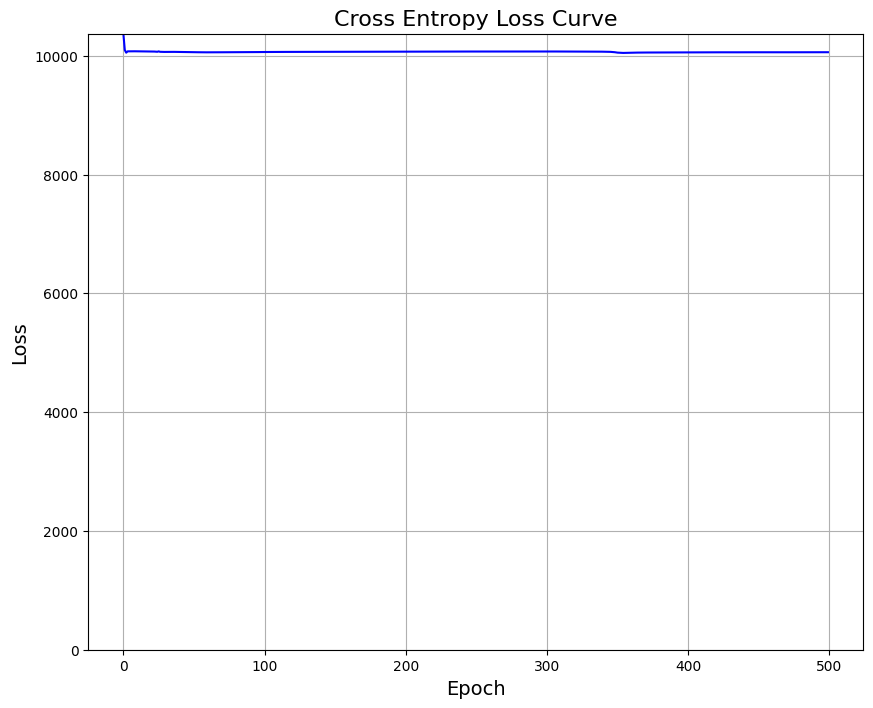

In [53]:
plt.figure(figsize=(10, 8))  # Adjust the figure size as needed
plt.plot(loss_list, color='blue', linewidth=1.5)
plt.title('Cross Entropy Loss Curve', fontsize=16)
plt.xlabel('Epoch', fontsize=14)
plt.ylabel('Loss', fontsize=14)
plt.ylim(0, max(loss_list)) 

plt.grid(True)
plt.show()

In [ ]:
# torch.save(model.state_dict(), 'lastOne.pth')

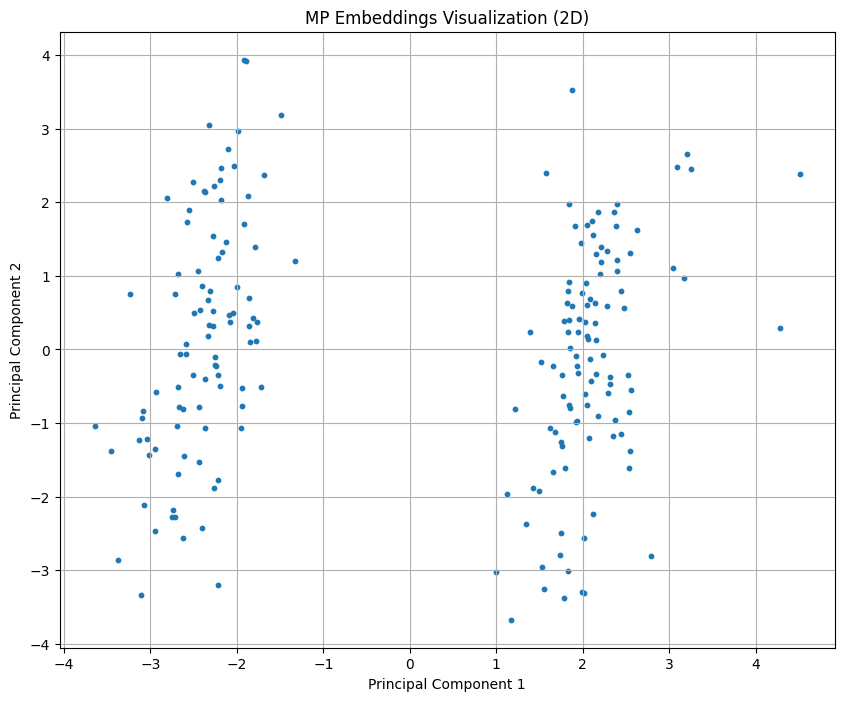

In [ ]:
embeddings = model.u_embeddings.weight.data.cpu().numpy()

pca = PCA(n_components=2)
embeddings_2d = pca.fit_transform(embeddings)

# Step 3: Plot embeddings
plt.figure(figsize=(10, 8))
plt.scatter(embeddings_2d[:, 0], embeddings_2d[:, 1], s=10)
plt.title('MP Embeddings Visualization (2D)')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')

plt.grid(True)
plt.show()

In [ ]:
print(len(embeddings))

199


In [ ]:
from sklearn.cluster import KMeans

Number of points in each cluster:
Cluster 0: 93 points
Cluster 1: 106 points


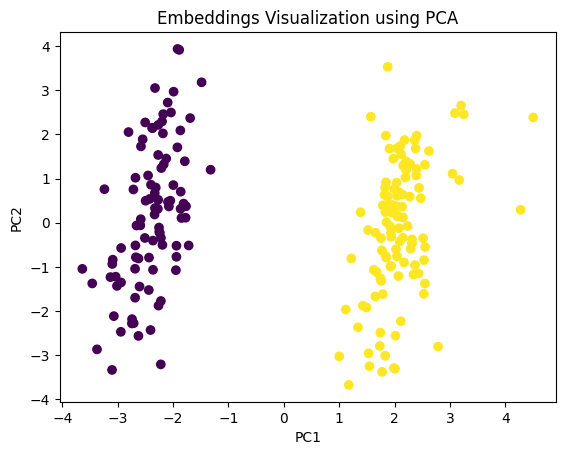

In [ ]:
def kmeans_cluster(embeddings, n_cluster=2):
    kmeans = KMeans(n_clusters=n_cluster).fit(embeddings)
    centres = kmeans.cluster_centers_
    labels = kmeans.labels_
    print("Number of points in each cluster:")
    for i in range(n_cluster):
        count = np.sum(labels == i)
        print(f"Cluster {i}: {count} points")
    return centres, labels

def pca(embeddings):
    pca = PCA(n_components=2)
    embeddings_2d = pca.fit_transform(embeddings)
    centres, labels = kmeans_cluster(embeddings_2d, 2)
    plt.scatter(embeddings_2d[:, 0], embeddings_2d[:, 1], c=labels, cmap='viridis')
    plt.title('Embeddings Visualization using PCA')
    plt.xlabel('PC1')
    plt.ylabel('PC2')
    plt.show()


pca(embeddings)
